# Introduction

In this note book, we present how we select features based on correlations with the Hall of Fame features. We also investigate the performance using Logistic regression.

# Feature Selection

### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold

import statsmodels.discrete.discrete_model as sm

import random

### Importing Data

In [2]:
# Import the data
player_stats_and_awards = pd.read_csv('./data/player_stats_and_awards.csv')

In [3]:
# All the features of the data
player_stats_and_awards.columns

Index(['Player', 'Birth Year', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Year_start', 'Year_end', 'Length', 'HOF', 'AllStar_MVP', 'Final_MVP',
       'DPOY', 'Final', 'Champion', 'AllStar', 'First team', 'Second team',
       'Third team', 'MVPs'],
      dtype='object')

Here, we choose to work with players who start their careers after 1982 and finish their careers before 2015. We also normalized all the features except 'HOF.'   

In [4]:
# data_in: data for training the model
data_in = player_stats_and_awards.query('Year_start >= 1982 & Year_end <= 2015')

# data_future: data for predicting future HOF inductees, need to be normalized the same way as data_in
data_future = player_stats_and_awards.query('Year_end > 2015')

# normalized data_in and data_future as X and X_future
X = data_in.drop(["Player","HOF"], axis = 1)
normalization_offset = X.mean()
normalization_scaling = X.std()
X = (X - normalization_offset)/normalization_scaling

X_future = data_future.drop(["Player","HOF"], axis = 1)
X_future = (X_future - normalization_offset)/normalization_scaling


y = data_in["HOF"]
data_normalized = pd.concat([X,y], axis=1)

We now present the function that select the important features (refered as representing features). This function first groups all the features based on correlations, except the feature of interest, 'HOF.' It then finds the representing features in the each group that have the highest correlations with 'HOF,' and return the result as a list.  

In [5]:
# Identify most important features by studying the correlations
def Feature_Selection(dataframe, target_feature, threshold):
    # All list of all the features
    columns_list = dataframe.columns.tolist()
    # remove the feature of interest, target_feature
    columns_list.remove(target_feature)
    # the list of representing features
    representing_feature_list = []
    # keep only the features that have the highest correlations with the target_feature.
    number_of_largest = 1
    while columns_list: 
        name = columns_list[0]
        df_temp = abs(dataframe[columns_list].corr())
    
        # identify the features that have high mutual correlations and group them.
        # High correlations indicate that those features might represent similar structure of the data
        group_index = df_temp.index[df_temp[name] > threshold]
    
        # For the features that have high correlations, find the representing features that have highest correlations with 'HOF'
        corr_target = abs(dataframe[group_index].corrwith(dataframe[target_feature]))
        representing_feature_list = representing_feature_list + list(corr_target.nlargest(n=number_of_largest).index)
        
        for x in list(group_index):
            columns_list.remove(x)
    
    # Sort the representing_feature_list according to correlatios with target_feature       
    representing_feature_list = list(dataframe[representing_feature_list].corrwith(dataframe[target_feature]).sort_values(ascending=False).index)
            
    return representing_feature_list

In [6]:
feature_list = Feature_Selection(data_normalized, 'HOF', 0.8)
print(data_normalized[feature_list].corrwith(data_normalized['HOF']).sort_values(ascending=False))

AllStar        0.834849
VORP           0.616421
WS             0.553751
AllStar_MVP    0.506579
First team     0.436193
AST            0.421578
Second team    0.418108
Third team     0.402422
BLK            0.360460
Final_MVP      0.348322
DPOY           0.320976
Final          0.281493
3PA            0.267193
BPM            0.181310
PER            0.178284
USG%           0.140627
AST%           0.114789
DBPM           0.103976
TS%            0.095486
3P%            0.067974
FT%            0.065818
DRB%           0.063592
BLK%           0.054436
TRB%           0.039168
FTr            0.030922
STL%           0.029409
3PAr          -0.012021
TOV%          -0.025935
Year_start    -0.097343
dtype: float64


## Logistic Regression

### Precision, Recall And F1 score

In [7]:
def Precision_Func(y_true,y_pred):
    y_true_np = np.array(y_true)
    y_pred_np= np.array(y_pred)
    y_true_positive_np = y_true_np & y_pred_np
    
    if sum(y_pred_np) > 0:
        precision = sum(y_true_positive_np)/sum(y_pred_np) 
    else:
        precision = -1 # if the no predictive positive, return a signal -1 
    
    return precision

In [8]:
def Recall_Func(y_true,y_pred):
    y_true_np = np.array(y_true)
    y_pred_np= np.array(y_pred)
    y_true_positive_np = y_true_np & y_pred_np
    
    if sum(y_true_np) > 0:
        recall = sum(y_true_positive_np)/sum(y_true_np) 
    else:
        recall = -1 # if the no true element, return a signal -1 
    
    return recall

In [9]:
def F1_Score_Func(y_true,y_pred):
    precision = Precision_Func(y_true,y_pred)
    recall = Recall_Func(y_true,y_pred)
    
    if (precision > 0) & (recall > 0):
        f1 = 2*precision*recall / (precision + recall)
    elif (precision == 0 ) & (recall == 0):
        # the limit of no true positive is f1 = 0
        f1 = 0
    elif (precision < 0) & (recall >= 0):
        # no predicted positive while true elements are present, it is reasonable to set f1 to zero
        f1 = 0
    elif (recall < 0) :
        # no ture elements to be learned from, there is issue in the training set
        f1 = -1
        print('There are no true examples in the training set!')
    
    return f1

### Learning Curve

##### Learning curve with the most important representing feature, 'AllStar.'

We now present the learning curve of the logistic regression with only the most important representing feature, 'AllStar.'

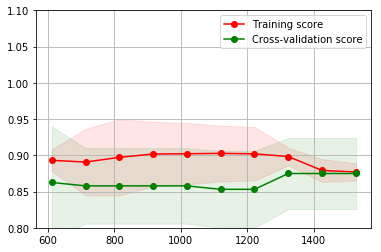

In [10]:
model = LogisticRegression(solver = 'lbfgs', C = 1e5, multi_class = 'multinomial')
X_in = data_normalized[feature_list[0:1]]
y_in = data_normalized['HOF']
X = X_in
y = y_in
n_size = 10;
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv = 5, n_jobs=1, train_sizes=np.linspace(.4, 1.0, n_size), scoring='f1',shuffle = True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.ylim(0.8, 1.1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

plt.savefig('test.png')

We find that the learning curve varies a lot as we rerun the script several times. This indicates that the number the data is not enough for the learning curve to converge to the statistical expectation. To overcome this, we apply bootstraping technique.

In [11]:
def Learning_Curve_Bootstraping(X_in, y_in, model_in, Bootstraping_size, train_sizes_list):

    train_scores_mean_list = np.zeros([len(train_sizes_list),Bootstraping_size])
    test_scores_mean_list = np.zeros([len(train_sizes_list),Bootstraping_size])
    for i in range(0,Bootstraping_size):
        model = sklearn.base.clone(model_in, safe=True)
        index_list = list(np.random.choice(range(0,X_in.shape[0]),replace=True,size = X_in.shape[0]))
        X = X_in.iloc[index_list]
        y = y_in.iloc[index_list]
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, n_jobs=1, cv=5, train_sizes=train_sizes_list, scoring="f1",shuffle = True)
        train_scores_mean_list[:,i] = np.mean(train_scores, axis=1)
        test_scores_mean_list[:,i] = np.mean(test_scores, axis=1)

    train_scores_mean = np.mean(train_scores_mean_list, axis=1)
    train_scores_std = np.std(train_scores_mean_list, axis=1)
    test_scores_mean = np.mean(test_scores_mean_list, axis=1)
    test_scores_std = np.std(test_scores_mean_list, axis=1)
    
    return train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Unde

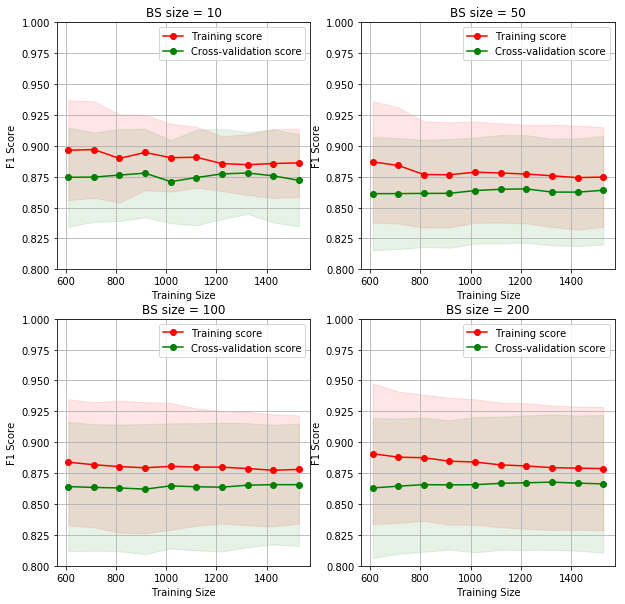

In [12]:
model_in = LogisticRegression(solver = 'lbfgs', C = 1e5, multi_class = 'multinomial')
X_in = data_normalized[feature_list[0:1]]
y_in = data_normalized['HOF']
train_sizes_list = np.linspace(.4, 1.0, 10)

plt.figure(figsize=(10,10))

i=0
for Bootstraping_size in [10, 50, 100, 200]:
    train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = Learning_Curve_Bootstraping(X_in, 
                                                       y_in, model_in, Bootstraping_size, train_sizes_list)
    plt.subplot(2,2,i+1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.title('BS size = {0:d}'.format(Bootstraping_size))
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.ylim(0.8,1.0)
    plt.legend(loc="best")
    i = i + 1
    

plt.show()

In [13]:
# Saving the data for the last figure
train_sizes_1 = train_sizes
train_scores_mean_1 = train_scores_mean
train_scores_std_1 = train_scores_std
test_scores_mean_1 = test_scores_mean
test_scores_std_1 = test_scores_std

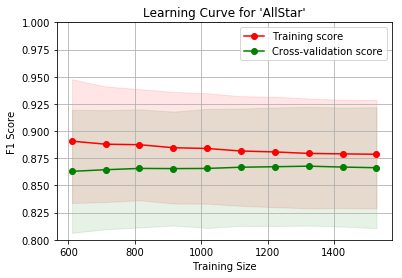

In [15]:
# saving the last figure

plt.grid()
plt.fill_between(train_sizes_1, train_scores_mean_1 - train_scores_std_1,
                 train_scores_mean_1 + train_scores_std_1, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_1, test_scores_mean_1 - test_scores_std_1,
                 test_scores_mean_1 + test_scores_std_1, alpha=0.1, color="g")
plt.plot(train_sizes_1, train_scores_mean_1, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_1, test_scores_mean_1, 'o-', color="g",
         label="Cross-validation score")
plt.title("Learning Curve for 'AllStar'")
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.ylim(0.8,1.0)
plt.legend(loc="best")
plt.savefig('./figures/feature-selection-logistic-regression/learn-curve-one-rep-feature.png')

As the number of the boostraping sets increases, the learning curve becomes smoother and shows consistent behavior. Based on the these learning curve, the model has low bias, as the f1 score can attain around 0.88, and low variance, as the gap between training score and cross-validation score is small. Next, we explore the possbility to improve the results by including more representing features. 

##### Learning curve with two most important representing features, 'AllStar' and 'VORP'

C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Weinei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Unde

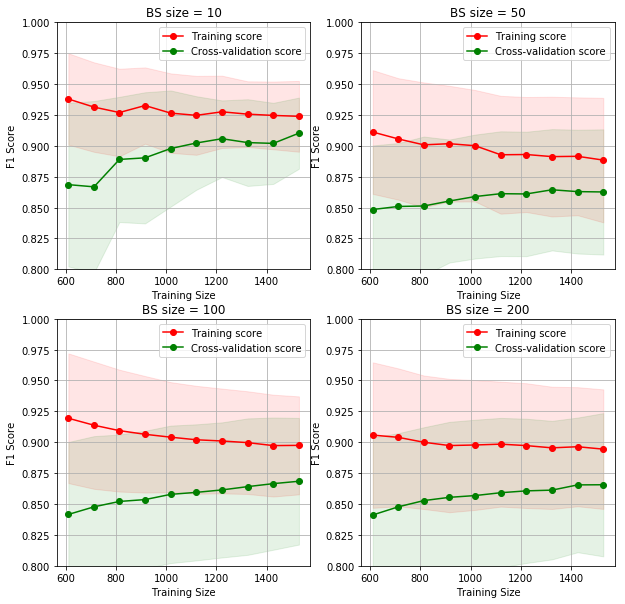

In [16]:
model_in = LogisticRegression(solver = 'lbfgs', C = 1e5, multi_class = 'multinomial')
X_in = data_normalized[feature_list[0:2]]
y_in = data_normalized['HOF']
train_sizes_list = np.linspace(.4, 1.0, 10)

plt.figure(figsize=(10,10))

i=0
for Bootstraping_size in [10, 50, 100, 200]:
    train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = Learning_Curve_Bootstraping(X_in, 
                                                       y_in, model_in, Bootstraping_size, train_sizes_list)
    plt.subplot(2,2,i+1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.title('BS size = {0:d}'.format(Bootstraping_size))
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.ylim(0.8,1.0)
    plt.legend(loc="best")
    i = i + 1
    

plt.show()

In [17]:
# Saving the data for the last figure
train_sizes_2 = train_sizes
train_scores_mean_2 = train_scores_mean
train_scores_std_2 = train_scores_std
test_scores_mean_2 = test_scores_mean
test_scores_std_2 = test_scores_std

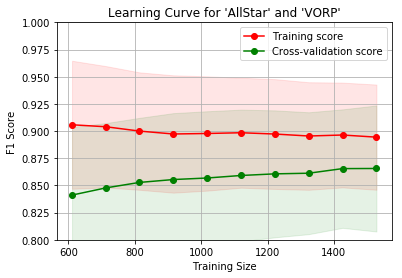

In [25]:
# saving the last figure
plt.grid()
plt.fill_between(train_sizes_2, train_scores_mean_2 - train_scores_std_2,
                 train_scores_mean_2 + train_scores_std_2, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_2, test_scores_mean_2 - test_scores_std_2,
                 test_scores_mean_2 + test_scores_std_2, alpha=0.1, color="g")
plt.plot(train_sizes_2, train_scores_mean_2, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_2, test_scores_mean_2, 'o-', color="g",
         label="Cross-validation score")
plt.title("Learning Curve for 'AllStar' and 'VORP'")
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.ylim(0.8,1.0)
plt.legend(loc="best")
plt.savefig('./figures/feature-selection-logistic-regression/learn-curve-two-rep-feature.png')

We find an f1 score around 0.9. Comparing to the previous model, this one has lower bias but higher variance, indicating more over-fitting than the previous model.

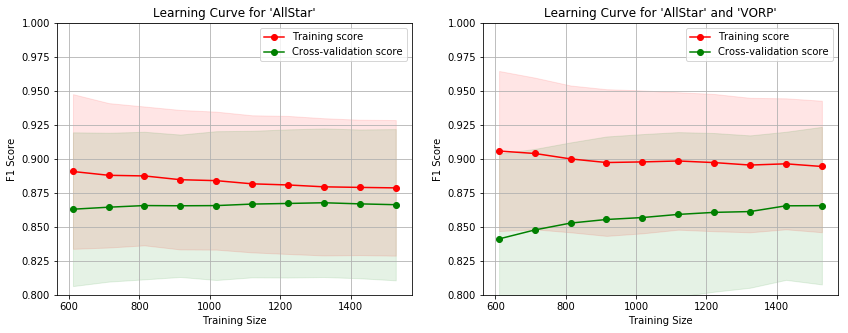

In [26]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.grid()
plt.fill_between(train_sizes_1, train_scores_mean_1 - train_scores_std_1,
                 train_scores_mean_1 + train_scores_std_1, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_1, test_scores_mean_1 - test_scores_std_1,
                 test_scores_mean_1 + test_scores_std_1, alpha=0.1, color="g")
plt.plot(train_sizes_1, train_scores_mean_1, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_1, test_scores_mean_1, 'o-', color="g",
         label="Cross-validation score")
plt.title("Learning Curve for 'AllStar'")
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.ylim(0.8,1.0)
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.grid()
plt.fill_between(train_sizes_2, train_scores_mean_2 - train_scores_std_2,
                 train_scores_mean_2 + train_scores_std_2, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_2, test_scores_mean_2 - test_scores_std_2,
                 test_scores_mean_2 + test_scores_std_2, alpha=0.1, color="g")
plt.plot(train_sizes_2, train_scores_mean_2, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_2, test_scores_mean_2, 'o-', color="g",
         label="Cross-validation score")
plt.title("Learning Curve for 'AllStar' and 'VORP'")
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.ylim(0.8,1.0)
plt.legend(loc="best")

plt.savefig('./figures/feature-selection-logistic-regression/learn-curve-combine.png')

### The Performance VS Number Of Representing Features

We now find the optimal number of representing features by using cross-validation curve. 

In [27]:
def Cross_Validation_Func(X,y,model_in,cv_n):
    # split the data into cv_n chunks
    skf = StratifiedKFold(n_splits=cv_n,shuffle=False)
    skf.get_n_splits(X, y)
  
    # For each iteration, test set is one chunk defined preciously and the rest are the training set
     
    train_f1_list = np.zeros(cv_n)
    test_f1_list = np.zeros(cv_n)
    
    i=0
    for train_list, test_list in skf.split(X, y):
        # reset model
        model = sklearn.base.clone(model_in, safe=True)
        X_train = X.iloc[train_list]
        y_train = y.iloc[train_list]
        X_test = X.iloc[test_list]
        y_test = y.iloc[test_list]
        
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_f1_list[i] = F1_Score_Func(y_train,y_pred_train)
        test_f1_list[i] = F1_Score_Func(y_test,y_pred_test)
        i=i+1
        
    # Return is the averaged f1 score for all iteration
    train_f1_ave = np.mean(train_f1_list)
    train_f1_std = np.std(train_f1_list)
    test_f1_ave = np.mean(test_f1_list)
    test_f1_std = np.std(test_f1_list)
    
    f1 = [train_f1_ave,train_f1_std,test_f1_ave,test_f1_std]
    
    return f1

In [28]:
def Validation_Curve_Bootstraping(X_in, y_in, model_in, cv_n,Bootstraping_size):

    train_scores_mean_list = np.zeros(Bootstraping_size)
    test_scores_mean_list = np.zeros(Bootstraping_size)
    for i in range(0,Bootstraping_size):
        model = sklearn.base.clone(model_in, safe=True)
        index_list = list(np.random.choice(range(0,X_in.shape[0]),replace=True,size = X_in.shape[0]))
        X = X_in.iloc[index_list]
        y = y_in.iloc[index_list]
        f1 = Cross_Validation_Func(X,y,model_in,cv_n)
        train_scores_mean_list[i] = f1[0]
        test_scores_mean_list[i] = f1[2]

    train_scores_mean = np.mean(train_scores_mean_list)
    train_scores_std = np.std(train_scores_mean_list)
    test_scores_mean = np.mean(test_scores_mean_list)
    test_scores_std = np.std(test_scores_mean_list)
    f1  = [train_scores_mean, train_scores_std, test_scores_mean, test_scores_std]
    
    return f1

In [31]:
def Validation_Curve_Plot(f1_train_ave,f1_train_std,f1_test_ave,f1_test_std,hyper_parameters,plot_type = 'plot',filename=None):
    para_name, para_list = hyper_parameters
    #plt.title("Validation Curve with {0} using Logistic Regression".format(para_name))
    plt.title("Validation Curve")
    plt.xlabel(para_name)
    plt.ylabel("F1 Score")
    plt.ylim(0.0, 1.1)
    line_width = 2
    if plot_type == 'plot':
        plt.plot(para_list, f1_train_ave, label="Training score",
                     color="darkorange", lw=line_width)
        plt.fill_between(para_list, f1_train_ave - f1_train_std,
                         f1_train_ave + f1_train_std, alpha=0.2,
                         color="darkorange", lw=line_width)
        plt.plot(para_list, f1_test_ave, label="Cross-validation score",
                     color="navy", lw=line_width)
        plt.fill_between(para_list, f1_test_ave - f1_test_std,
                         f1_test_ave + f1_test_std, alpha=0.2,
                         color="navy", lw=line_width)
    elif plot_type == 'semilogx':
        plt.semilogx(para_list, f1_train_ave, label="Training score",
                     color="darkorange", lw=line_width)
        plt.fill_between(para_list, f1_train_ave - f1_train_std,
                         f1_train_ave + f1_train_std, alpha=0.2,
                         color="darkorange", lw=line_width)
        plt.semilogx(para_list, f1_test_ave, label="Cross-validation score",
                     color="navy", lw=line_width)
        plt.fill_between(para_list, f1_test_ave - f1_test_std,
                         f1_test_ave + f1_test_std, alpha=0.2,
                         color="navy", lw=line_width)
    plt.legend(loc="best")
    
    if  filename!= None:
        plt.savefig(filename)
    
    plt.show()

    

Due to limited amount of data, we again use bootstraping technique to evalyate the cross validation curve.

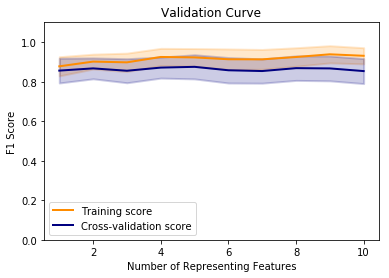

In [32]:
length = 10
Bootstraping_size = 100
f1_list = np.zeros([length,4])
y = data_normalized['HOF']
cv_n = 10
model = LogisticRegression(solver = 'lbfgs', C = 1e5, multi_class = 'multinomial')
for i in range(0,length):
    X = data_normalized[feature_list[0:(i+1)]]
    f1 = Validation_Curve_Bootstraping(X,y,model,cv_n,Bootstraping_size)
    f1_list[i,:] = f1


filename = './figures/feature-selection-logistic-regression/cross-validation-number-of-features.png';
Validation_Curve_Plot(f1_list[:,0],f1_list[:,1], f1_list[:,2], f1_list[:,3], 
                      ('Number of Representing Features',np.arange(1,length+1)),'plot',filename)


In [27]:
print(np.concatenate((f1_list[:,0:1],f1_list[:,2:3]),axis=1))

[[0.87519732 0.85586089]
 [0.9000513  0.86339488]
 [0.90017527 0.86332489]
 [0.9209062  0.86519762]
 [0.91876425 0.87230733]
 [0.91824652 0.86235714]
 [0.92266775 0.86356775]
 [0.92247401 0.86880224]
 [0.92914245 0.85861739]
 [0.93458809 0.85354185]]


In [48]:
f1_list

array([[0.87712418, 0.04385632, 0.85598687, 0.05953861],
       [0.90045248, 0.04685317, 0.87070974, 0.06080234],
       [0.90393979, 0.05026403, 0.8536127 , 0.0632223 ],
       [0.92295993, 0.04380309, 0.86690491, 0.06026299],
       [0.92010724, 0.04210709, 0.8678233 , 0.05578517],
       [0.92562068, 0.04735192, 0.86817092, 0.06631906],
       [0.91489688, 0.05016374, 0.85425743, 0.06574871],
       [0.92480199, 0.04766951, 0.86831825, 0.06253407],
       [0.92379803, 0.04493906, 0.86015317, 0.05734609],
       [0.93632819, 0.04598811, 0.8581974 , 0.06609837]])

The results shows that the training score is increasing while the validation score is saturating. This indicates the optimal number of representing features is actually one, consistent with the results from learning curve. In the following, we explore if using regularization could improve the results for the case of one representing feature and two.

### Regularization

#### One representing feature

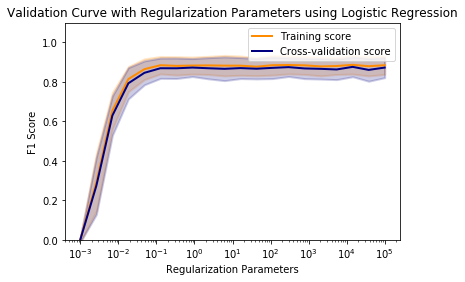

In [28]:
X = data_normalized[feature_list[0:1]]
y = data_normalized['HOF']
cv_n = 5
Bootstraping_size = 100

log_C_list = np.linspace(-3,5,20)
C_list = 10**(log_C_list)
f1_list = np.zeros([len(C_list),4])

for i in range(0,len(C_list)):
    model = LogisticRegression(solver = 'lbfgs', C = C_list[i], multi_class = 'multinomial')
    f1 = Validation_Curve_Bootstraping(X,y,model,cv_n,Bootstraping_size)
    f1_list[i,:] = f1


Validation_Curve_Plot(f1_list[:,0],f1_list[:,1], f1_list[:,2], f1_list[:,3], 
                      ('Regularization Parameters',C_list),plot_type='semilogx')

The optimal regularization parameter typically locates at the peak of cross-validation curve. Instead of a peak, the plot shows that the cross-validation score saturates when the regularization parameter is large than roughly 0.05, which indicates that regularization would not improve the results. 

#### Two representing features

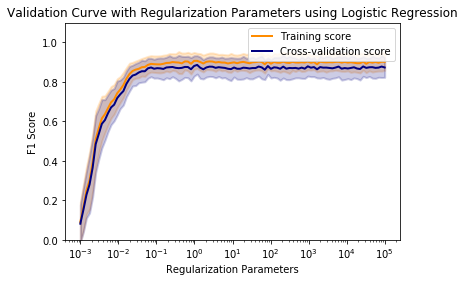

In [29]:
X = data_normalized[feature_list[0:2]]
y = data_normalized['HOF']
cv_n = 5
Bootstraping_size = 100

log_C_list = np.linspace(-3,5,100)
C_list = 10**(log_C_list)
f1_list = np.zeros([len(C_list),4])

for i in range(0,len(C_list)):
    model = LogisticRegression(solver = 'lbfgs', C = C_list[i], multi_class = 'multinomial')
    f1 = Validation_Curve_Bootstraping(X,y,model,cv_n,Bootstraping_size)
    f1_list[i,:] = f1


Validation_Curve_Plot(f1_list[:,0],f1_list[:,1], f1_list[:,2], f1_list[:,3], 
                      ('Regularization Parameters',C_list),plot_type='semilogx')

Again, as the cross-validation curve saturates, regularization wouldn't improve the results.

### Results

We now present the results for one representing feature and two.

### One representing feature, AllStar

We first plot the distribution of number of All stars with respect to whether the player is a Hall of Fame inductee. 

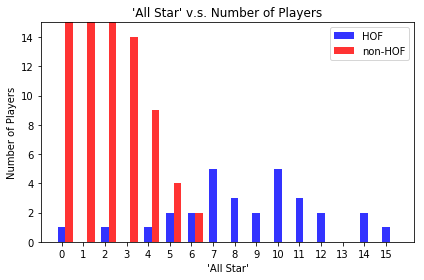

In [34]:
X_in = data_in['AllStar']
y_in = data_normalized['HOF']


# data to plot
n_groups = max(X_in)- min(X_in)+1

index = np.arange(n_groups)
X_in_1 = X_in[y_in==1]
X_in_1_hist = [sum(X_in_1==i) for i in list(index)]
X_in_0 = X_in[y_in==0]
X_in_0_hist = [sum(X_in_0==i) for i in list(index)]
 
# create plot
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, X_in_1_hist, bar_width,
alpha=opacity,
color='b',
label='HOF')
 
rects2 = plt.bar(index + bar_width, X_in_0_hist, bar_width,
alpha=opacity,
color='r',
label='non-HOF')

plt.ylim(0,15)
plt.xticks(index)
plt.xlabel("'All Star'")
plt.ylabel('Number of Players')
plt.title("'All Star' v.s. Number of Players")
plt.legend()
 
plt.tight_layout()
plt.savefig('./figures/feature-selection-logistic-regression/distribution-one-rep-feature.png')
plt.show()

This plot shows that players who have played in the all star games at least seven times are all Hall of Fame inductees. Players who have played six times have one half probability being inducted. And the probability goes down quickly for players who play less then five times. We now explore people who are Hall of Fame inductees but have only played at most six times. 

In [31]:
data_in.query('(AllStar<=6) & (HOF==1)')[['Player','AllStar']].sort_values('AllStar')

,Player,AllStar
169,Arvydas Sabonis,0.0
685,Dennis Rodman,2.0
2104,Ralph Sampson,4.0
446,Chris Mullin,5.0
2152,Reggie Miller,5.0
1309,Joe Dumars,6.0
1919,Mitch Richmond,6.0


The first player, Arvydas Sabonis, is inducted in recognition of his achievement in international competition but has no outstanding NBA career. This person should be an outlier. We are going to remove him from now on. The rest of them all have outstanding NBA careers.

We also take a look at players who have played six all star games but have not been inducted into hall of fame.

In [32]:
data_in.query('(AllStar >=6) & (HOF==0)')[['Player','AllStar']].sort_values('AllStar')

,Player,AllStar
1248,Jermaine O'Neal,6.0
2376,Shawn Kemp,6.0


We notice there are many discussions about why Shawn Kemp has not been inducted as a Hall of famer. Also, Jermaine O'Neal just retired in 2014 and we believe he will be inducted soon.

We now apply logistic regression and show the probability of being inducted versus the number of all star games played.

In [58]:
X_in = X[['AllStar']].drop(axis=0,index=169)
y_in = y.drop(axis=0,index=169)
model = LogisticRegression(solver = 'lbfgs', C = 1e5, multi_class = 'multinomial')
model.fit(X_in, y_in)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [59]:
y_pred = model.predict(X_in)
print([Precision_Func(y_in,y_pred),Recall_Func(y_in,y_pred),F1_Score_Func(y_in,y_pred)])

[0.9259259259259259, 0.8620689655172413, 0.8928571428571429]


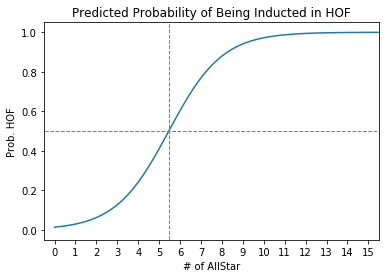

In [60]:
X_Full = pd.DataFrame(data = {'AllStar': np.linspace(0,16,1000)})

prob_Full = model.predict_proba((X_Full- normalization_offset['AllStar'])/normalization_scaling['AllStar'])[:,1]

boundary_one_rep_feature = X_Full[prob_Full>0.5].min().values
plt.plot(X_Full,prob_Full)
plt.plot([-1,16],[0.5,0.5],color = 'tab:gray', linestyle='--',linewidth = 1.0)
plt.plot(boundary_one_rep_feature*[1,1],[-0.1,1.1],color = 'tab:gray', linestyle='--',linewidth = 1.0)
plt.xticks(range(0,16))
plt.xlim(-0.5,15.5)
plt.ylim(-0.05,1.05)
_ = plt.xlabel('# of AllStar')
_ = plt.ylabel('Prob. HOF')
_ = plt.title('Predicted Probability of Being Inducted in HOF')

plt.savefig('./figures/feature-selection-logistic-regression/probability-one-rep-feature.png')
plt.show()

In [36]:
df_coef = pd.DataFrame(model.coef_,columns=['AllStar'])
print(df_coef)

    AllStar
0  0.977502


The results shows that the players who have played more than five all star games have probability higher than 50% to be inducted in Hall of Fame. We now see how this applies to the players who finish their careers after 2015 or are still playing.

In [37]:
X_future_in = np.c_[X_future['AllStar']]

data_future_pred = pd.DataFrame()
data_future_pred['Player'] = data_future['Player']
data_future_pred['AllStar'] = data_future['AllStar']
data_future_pred['HOF'] = model.predict(X_future_in)
data_future_pred['HOF_Prob'] = model.predict_proba(X_future_in)[:,1]

##### Players who will be inducted:

In [38]:
data_future_pred[(data_future_pred['HOF']==1)][['Player','HOF_Prob']].sort_values('HOF_Prob',ascending = False)

,Player,HOF_Prob
1557,Kobe Bryant,0.999945
1520,Kevin Garnett,0.999426
2517,Tim Duncan,0.999426
1628,LeBron James,0.999426
745,Dirk Nowitzki,0.998747
807,Dwyane Wade,0.997264
419,Chris Bosh,0.987053
366,Carmelo Anthony,0.972120
2044,Paul Pierce,0.972120
1517,Kevin Durant,0.972120


##### Players who should be inducted but are predicted with less than 50% chances

We use our own impression about the current players and find out that there are some players who should be inducted but are predicted with less than 50% chances based on our model.

We believe some players who have attended five all star games before 2019 are likely to attend more and thus have more than 50% chance to be inducted in Hall of Fame

In [39]:
data_future_pred[(data_future_pred['AllStar']==5)][['Player','HOF_Prob']].sort_values('HOF_Prob',ascending = False)

,Player,HOF_Prob
29,Al Horford,0.411007
1364,John Wall,0.411007
1527,Kevin Love,0.411007
1556,Klay Thompson,0.411007
1574,Kyle Lowry,0.411007


Based on our impresssion, we also believe Klay Thompson and Rajon Rondo are likely to be Hall of Famers

In [40]:
data_future_pred.query('(Player == "Klay Thompson") | (Player == "Rajon Rondo")')[['Player','HOF_Prob','AllStar']]

,Player,HOF_Prob,AllStar
1556,Klay Thompson,0.411007,5.0
2100,Rajon Rondo,0.241939,4.0


### Using statsmodels

We can also perform logistic regression by using python package statsmodels. Please note that the fitted coefficient is twice as large as the coefficient by using sklearn because different convention in the model.

In [75]:
import statsmodels.api as sm

X_sm_in = X_in.copy()
X_sm_in['Intercept'] = 1
sm_logit = sm.Logit(y_in,X_sm_in)
sm_logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.008849
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    HOF   No. Observations:                 1910
Model:                          Logit   Df Residuals:                     1908
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Mar 2019   Pseudo R-squ.:                  0.8875
Time:                        12:07:13   Log-Likelihood:                -16.901
converged:                       True   LL-Null:                       -150.22
                                        LLR p-value:                 6.146e-60
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AllStar        1.9550      0.326      5.990      0.000       1.315       2.595
Intercept     -8.1640      1.230     -6.640      0.000     -10.574      -5.754
==============================================================================
"""

Based on above results, the coefficient for feature AllStar has statistical significance.

### Two Representing features, AllStar and VORP

We first plot the dependence of whether the player is a Hall of Fame inductee on the number of all star games he plays and his value over replacement player (VORP). 

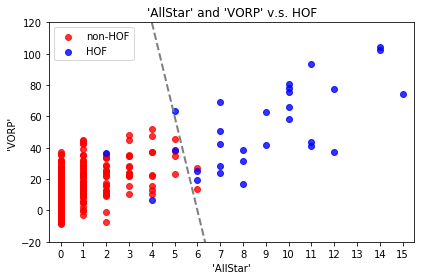

In [44]:
X_in = data_in[['AllStar','VORP']].drop(axis=0,index=169)
y_in = data_normalized['HOF'].drop(axis=0,index=169)


# data to plot
X_in_1 = X_in[y_in==1]
X_in_0 = X_in[y_in==0]
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
opacity = 0.8

plt.scatter(X_in_0['AllStar'], X_in_0['VORP'],
            alpha=opacity,
            color='r',
            marker = 'o',label='non-HOF')
plt.scatter(X_in_1['AllStar'], X_in_1['VORP'],
            alpha=opacity,
            color='b',
            marker = 'o',label='HOF')
plt.plot([4,5,6,7],[120,60,0,-60],color = 'tab:gray', linestyle='--',linewidth = 2.0)
plt.xlim(-0.5,15.5)
plt.ylim(-20,120)

plt.xticks(index)
plt.xlabel("'AllStar'")
plt.ylabel("'VORP'")
plt.title("'AllStar' and 'VORP' v.s. HOF")
plt.legend()
 
plt.tight_layout()
plt.savefig('./figures/feature-selection-logistic-regression/distribution-two-rep-feature.png')
plt.show()

We now apply logistic regression and show the probability of being inducted versus the number of all star game played.

In [41]:
X_in = X[feature_list[0:2]].drop(axis=0,index=169)
y_in = y.drop(axis=0,index=169)
model = LogisticRegression(solver = 'lbfgs', C = 1e5, multi_class = 'multinomial')
model.fit(X_in, y_in)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [42]:
y_pred = model.predict(X_in)
print([Precision_Func(y_in,y_pred),Recall_Func(y_in,y_pred),F1_Score_Func(y_in,y_pred)])

[0.9285714285714286, 0.896551724137931, 0.912280701754386]


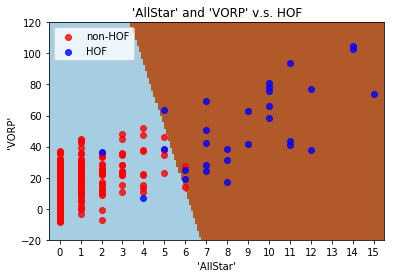

In [43]:
h = 0.1
x_min = data_in[['AllStar']].min().values-1; x_max = data_in[['AllStar']].max().values+1;
y_min = data_in[['VORP']].min().values-20; y_max = data_in[['VORP']].max().values+20;
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
Z = model.predict(np.c_[(xx.ravel()-normalization_offset[['AllStar']].values)/normalization_scaling[['AllStar']].values, 
                        (yy.ravel()-normalization_offset[['VORP']].values)/normalization_scaling[['VORP']].values])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X_in_0['AllStar'], X_in_0['VORP'],
            alpha=opacity,
            color='r',
            marker = 'o',label='non-HOF')
plt.scatter(X_in_1['AllStar'], X_in_1['VORP'],
            alpha=opacity,
            color='b',
            marker = 'o',label='HOF')
plt.xlim(-0.5,15.5)
plt.ylim(-20,120)

plt.xticks(index)
plt.xlabel("'AllStar'")
plt.ylabel("'VORP'")
plt.title("'AllStar' and 'VORP' v.s. HOF")
plt.legend()
plt.savefig('./figures/feature-selection-logistic-regression/classification-two-rep-feature.png')
plt.show()

In [80]:
X_future_in = X_future[['AllStar','VORP']]

data_future_pred = pd.DataFrame()
data_future_pred['Player'] = data_future['Player']
data_future_pred['AllStar'] = data_future['AllStar']
data_future_pred['VORP'] = data_future['VORP']
data_future_pred['HOF'] = model.predict(X_future_in)
data_future_pred['HOF_Prob'] = model.predict_proba(X_future_in)[:,1]

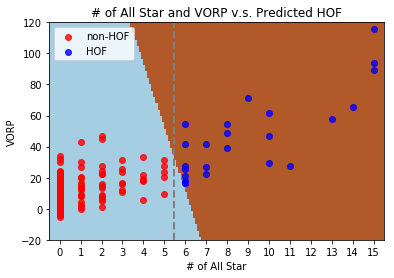

In [81]:
# Compare with the class boundary predited by using only 'AllStar'
X_future_0 = data_future_pred[data_future_pred['HOF'] == 0]
X_future_1 = data_future_pred[data_future_pred['HOF'] == 1]

plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X_future_0['AllStar'], X_future_0['VORP'],
            alpha=opacity,
            color='r',
            marker = 'o',label='non-HOF')
plt.scatter(X_future_1['AllStar'], X_future_1['VORP'],
            alpha=opacity,
            color='b',
            marker = 'o',label='HOF')
plt.plot(boundary_one_rep_feature*[1,1],[-20,120],color = 'tab:gray', linestyle='--',linewidth = 2.0)
plt.xlim(-0.5,15.5)
plt.ylim(-20,120)

plt.xticks(index)
plt.xlabel('# of All Star')
plt.ylabel('VORP')
plt.title('# of All Star and VORP v.s. Predicted HOF')
plt.legend()
plt.savefig('./figures/feature-selection-logistic-regression/prediction-two-rep-feature.png')
plt.show()

In [82]:
df_coef = pd.DataFrame(model.coef_,columns=['AllStar','VORP'])
print(df_coef)

    AllStar      VORP
0  0.905694  0.176331


##### Players who will be inducted:

In [83]:
data_future_pred[(data_future_pred['HOF']==1)][['Player','HOF_Prob']].sort_values('HOF_Prob',ascending = False)

,Player,HOF_Prob
1557,Kobe Bryant,0.999944
1628,LeBron James,0.999772
1520,Kevin Garnett,0.999664
2517,Tim Duncan,0.999634
745,Dirk Nowitzki,0.998855
807,Dwyane Wade,0.997290
419,Chris Bosh,0.980523
2044,Paul Pierce,0.977990
1517,Kevin Durant,0.971733
449,Chris Paul,0.962600


##### Players who should be inducted but are predicted with less than 50% chances

We use our own impression about the current players and find out that there are a few players who should be inducted but are predicted with less than 50% chances based on our model.

We believe that some players who has attended five all star games before 2019 are likely to attend more and thus have more than 50% chance to be inducted in Hall of Fame

In [84]:
data_future_pred[(data_future_pred['AllStar']==5)][['Player','HOF_Prob','AllStar',
                                                   'VORP']].sort_values('HOF_Prob',ascending = False)

,Player,HOF_Prob,AllStar,VORP
1574,Kyle Lowry,0.411155,5.0,31.5
29,Al Horford,0.392862,5.0,27.2
1527,Kevin Love,0.377357,5.0,23.5
1364,John Wall,0.364146,5.0,20.3
1556,Klay Thompson,0.321521,5.0,9.6


In [85]:

data_future_pred_temp = pd.DataFrame()
data_future_pred_temp['Player'] = data_future['Player'].loc[[1580,2037,2423]].copy()
data_future_pred_temp['AllStar'] = data_future['AllStar'].loc[[1580,2037,2423]].copy()+1
data_future_pred_temp['VORP'] = data_future['VORP'].loc[[1580,2037,2423]].copy()

X_temp = (data_future_pred_temp[['AllStar','VORP']].copy()-normalization_offset[['AllStar','VORP']].values)/normalization_scaling[['AllStar','VORP']].values


data_future_pred_temp['HOF'] = model.predict(X_temp)
data_future_pred_temp['HOF_Prob'] = model.predict_proba(X_temp)[:,1]

data_future_pred_temp

,Player,AllStar,VORP,HOF,HOF_Prob
1580,Kyrie Irving,7.0,16.3,1,0.694534
2037,Paul George,7.0,21.2,1,0.712617
2423,Stephen Curry,7.0,41.8,1,0.781207


Based on our impresssion, we also believe Klay Thompson and Rajon Rondo are likely to be Hall of Famers

In [86]:
data_future_pred.query('(Player == "Klay Thompson") | (Player == "Rajon Rondo")')[['Player','HOF_Prob','AllStar','VORP']]

,Player,HOF_Prob,AllStar,VORP
1556,Klay Thompson,0.321521,5.0,9.6
2100,Rajon Rondo,0.222025,4.0,21.9


### Using statsmodels

We can also perform logistic regression by using python package statsmodels. Please note that the fitted coefficient is twice as large as the coefficient by using sklearn because different convention in the model.

In [87]:
X_sm_in = X_in.copy();
X_sm_in['Intercept'] = 1;
sm_logit = sm.Logit(y_in,X_sm_in)
sm_logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.008533
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    HOF   No. Observations:                 1910
Model:                          Logit   Df Residuals:                     1907
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Mar 2019   Pseudo R-squ.:                  0.8915
Time:                        12:07:29   Log-Likelihood:                -16.297
converged:                       True   LL-Null:                       -150.22
                                        LLR p-value:                 6.901e-59
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AllStar        1.8114      0.365      4.957      0.000       1.095       2.528
VORP           0.3527      0.322      1.094      0.274      -0.279       0.985
Intercept     -8.6284      1.495     -5.773      0.000     -11.558      -5.699
==============================================================================
"""

Based on above results, the coefficient for feature AllStar again has statistical significance. However, the coefficient for feature VORP doesn't have statistical significance. Increasing number of data might decrease the corresponding P-value.